Nome: Felipe Bortolletto

Professor: Prof. Anderson Ara

Disciplina: TEORIA DO APRENDIZADO ESTAT ́ISTICO

Data: 26 de abril de 2024

Aplicação da metodologia de rede neural com a biblioteca pytorch para os dados RICE



In [1]:
!pip install ucimlrepo

In [2]:
from ucimlrepo import fetch_ucirepo

# fetch dataset
rice_cammeo_and_osmancik = fetch_ucirepo(id=545)

# data (as pandas dataframes)
X = rice_cammeo_and_osmancik.data.features
y = rice_cammeo_and_osmancik.data.targets

X.shape,y.shape


((3810, 7), (3810, 1))

In [3]:
y['Class'].replace({'Cammeo': 0, 'Osmancik': 1},inplace = True)
y

<ipython-input-3-ee9f0d4414e2>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  y['Class'].replace({'Cammeo': 0, 'Osmancik': 1},inplace = True)


,Class
0,0
1,0
2,0
3,0
4,0
...,...
3805,1
3806,1
3807,1
3808,1


No comando acima substituimos os nomes das classe, agora as classes se tornão  

Cammeo: 0

Osmancik: 1

Alem disso abaixo iremos normalizar os dados

In [4]:
from sklearn.model_selection import train_test_split

from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()

import pandas as pd
import numpy as np

import matplotlib.pyplot as plt


X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)
y_test = y_test.values.flatten()
y_train = y_train.values.flatten()
# print(X_train)
X_train.shape,X_test.shape,y_train.shape,y_test.shape

((3048, 7), (762, 7), (3048,), (762,))

Vamos criar nosso modelo de rede neural!

In [5]:
import torch

X_train = torch.from_numpy(X_train.astype(np.float32))
y_train = torch.from_numpy(y_train.astype(np.float32))
X_test = torch.from_numpy(X_test.astype(np.float32))
y_test = torch.from_numpy(y_test.astype(np.float32))

X_train.shape,X_test.shape,y_train.shape,y_test.shape

(torch.Size([3048, 7]),
 torch.Size([762, 7]),
 torch.Size([3048]),
 torch.Size([762]))

### Criamos a baixo a classe de nosso modelo

In [8]:


from torch import nn


class MLPV0(nn.Module):
  def __init__(self,
               input_size = 7,
            hiden_layers = 32,
            output_size = 1):
    super().__init__()
    self.linear_RELU = nn.Sequential(
                nn.Linear(input_size, hiden_layers),
                nn.ReLU(),
                nn.Linear(hiden_layers, hiden_layers),
                nn.ReLU(),
                nn.Linear(hiden_layers, output_size),
                # nn.Sigmoid()
            )

  def forward(self,x):
    # return torch.round(self.linear_RELU(x))
    return self.linear_RELU(x)

### E agora uma função para treino e outra para calcular a acc

In [15]:
def accuracy_fn(y_true,y_pred):
    correct = torch.eq(y_true,y_pred).sum().item() #torch.eq -> how many samples are equal
    acc = (correct/len(y_pred)) * 100
    return acc

def train(model,
          learning_rate,
          X_train,
          y_train,
          x_test,
          y_test,
          epochs = 200):
  # Loss and optimizer
  criterion = nn.BCEWithLogitsLoss()
  optimizer = torch.optim.SGD(model.parameters(),
                              lr=learning_rate)

  train_losses = np.zeros(epochs)
  test_losses = np.zeros(epochs)

  for epoch in range(epochs):
    model.train()
    y_logits = model(X_train).squeeze()
    y_pred = torch.round(torch.sigmoid(y_logits))


    loss = criterion(y_logits, y_train)
    train_losses[epoch] = loss.item()
    acc = accuracy_fn(y_train,y_pred)
    # Backpropagation

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    model.eval()
    with torch.inference_mode():
    #Train loss
      test_logits = model(X_test).squeeze()
      test_pred = torch.round(torch.sigmoid(test_logits))

      test_loss = criterion(test_logits, y_test)
      test_acc = accuracy_fn(y_test,test_pred)

      test_losses[epoch] = test_loss.item()

      if epoch % 20 == 0:

            print(f"Epoch: {epoch} | Train Loss: {loss:5f} | Acc: {acc:5f}% | Test Loss:{test_loss:2f} | Test acc:{test_acc:2f}%" )


  return train_losses, test_losses

In [16]:
model = MLPV0()
# model.state_dict()
untrained_preds = model(X_test)
print(f"length of predictions: {len(untrained_preds)}, Shape: {untrained_preds.shape}")
print(f"length of test samples: {len(X_test)}, Shape: {X_test.shape}")
print(f"\nFirst 10 predictions:\n{untrained_preds[:10]}")
print(f"\nFirst 10 labels:\n{y_test[:10]}")


length of predictions: 762, Shape: torch.Size([762, 1])
length of test samples: 762, Shape: torch.Size([762, 7])

First 10 predictions:
tensor([[ 0.0033],
        [ 0.0332],
        [ 0.0151],
        [-0.0638],
        [-0.0101],
        [-0.0539],
        [ 0.0360],
        [-0.0284],
        [-0.0290],
        [-0.0715]], grad_fn=<SliceBackward0>)

First 10 labels:
tensor([0., 1., 1., 0., 1., 0., 1., 0., 0., 0.])


Epoch: 0 | Train Loss: 0.684655 | Acc: 73.162730% | Test Loss:0.677511 | Test acc:82.283465%
Epoch: 20 | Train Loss: 0.529646 | Acc: 87.696850% | Test Loss:0.529631 | Test acc:87.401575%
Epoch: 40 | Train Loss: 0.333684 | Acc: 91.994751% | Test Loss:0.330737 | Test acc:92.519685%
Epoch: 60 | Train Loss: 0.232648 | Acc: 92.125984% | Test Loss:0.225672 | Test acc:92.257218%
Epoch: 80 | Train Loss: 0.203663 | Acc: 92.322835% | Test Loss:0.194012 | Test acc:92.257218%
Epoch: 100 | Train Loss: 0.194363 | Acc: 92.519685% | Test Loss:0.183241 | Test acc:92.388451%
Epoch: 120 | Train Loss: 0.190604 | Acc: 92.650919% | Test Loss:0.178807 | Test acc:92.519685%
Epoch: 140 | Train Loss: 0.188815 | Acc: 92.814961% | Test Loss:0.176717 | Test acc:92.650919%
Epoch: 160 | Train Loss: 0.187834 | Acc: 92.913386% | Test Loss:0.175652 | Test acc:92.650919%
Epoch: 180 | Train Loss: 0.187240 | Acc: 92.979003% | Test Loss:0.175086 | Test acc:92.519685%
Epoch: 200 | Train Loss: 0.186819 | Acc: 92.979003% | Te

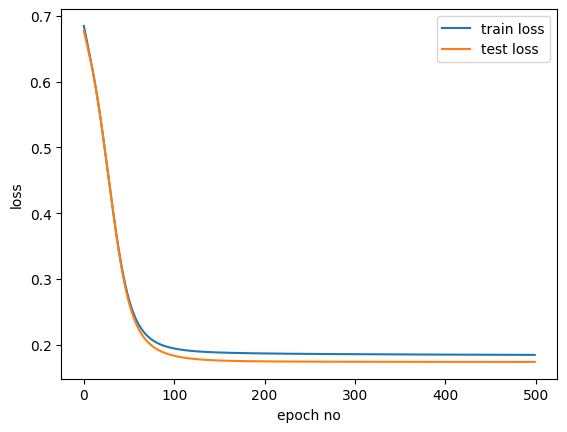

In [17]:
lr = 0.1
epochs = 500
train_losses, test_losses = train(model,
                                  lr,
                                  X_train,
                                  y_train,
                                  X_test,
                                  y_test,
                                  epochs)

plt.plot(train_losses, label='train loss')
plt.plot(test_losses, label='test loss')
plt.xlabel('epoch no')
plt.ylabel('loss')
plt.legend()
plt.savefig("erro.png", dpi=300)
plt.show()


In [19]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

y_pred = torch.round(torch.sigmoid(model(X_test).squeeze())).detach().numpy()
y_true = y_test

accuracy = accuracy_score(y_true, y_pred)
precision = precision_score(y_true, y_pred, average='weighted')
recall = recall_score(y_true, y_pred, average='weighted')
f1 = f1_score(y_true, y_pred, average='weighted')

print(f'Accuracy: {accuracy:.5f}')
print(f'Precision: {precision:.5f}')
print(f'Recall: {recall:.5f}')
print(f'F1 Score: {f1:.5f}')

Accuracy: 0.92651
Precision: 0.92655
Recall: 0.92651
F1 Score: 0.92652
